## Linear Regression
Implementing linear regression, this will be generlized for both univariate and multivariate.

key skills to learn 
 - Univarite
 - Multivarite
 - Feature scaling
 - hypothesis or model prediction
 - weights initialization
 - Gradient computation
 - Cost function 
 - Gradient descent update
 - plot cost 
 
 

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sklearn
import random
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

## Diabetes dataset 
This dataset is already preprocessed and divided into features and labels, we will use it to
train linear regression models such multivarite and univariate.

In [93]:
# get linear regression dataset from sklearn
diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True)


X_train = diabetes_X
Y_train = diabetes_y.reshape(1, -1).T

## Define Regression model
- option to define any hypothesis such uni and multivarite
- weights initialization
- feature scaling if not performed already 


In [75]:
#Test cases cost funtion
predictions = np.array([[1, 1, 1, 0]], dtype = np.float32)
labels = np.array([[1, 0, 1, 0]], dtype = np.float32)
print(f"Cost: " + str(compute_cost(labels, predictions)))

Cost: 0.125


## Calculate Derivate of cost with respect to parameters
compute_gradients function calculates derivates of cost with respect to each of the parameters.
The size of graidents should be same as paramters

In [76]:
def compute_gradients(X, Y, params):
    """calculate gradients of the cost with respect params
    
    Parameters
    ----------
    X: np.ndarray
       features 
    Y: np.ndarray
       labels
    params: np.ndarray
       model paramters
    model: Model
       linear regression hypothesis
    """

    m = X.shape[0]
    X = np.insert(X, 0, 1, axis = 1)
    Y = Y.reshape(1, -1).T
    dev = (1/m) * np.transpose(X) @ (X @ params - Y) 

    return dev

In [80]:
# #check gradients
# gradients = compute_gradients(X_train, Y_train, params)
# assert gradients.shape == params.shape, "Error, shape doesnt match"

## Apply Gradient Descent update 
apply gradient descent algorithm to update the parameters using gradient you calculated in the previous step.

In [81]:
def gradient_descent(gradients, params, learning_rate = 1e-2):
    '''gradient descent update
    
    Parameters
    ----------
    gradients: np.ndarray
               derivatives of the cost w.r.t to params
    params: np.ndarray
               model params
    learning_rate: float
               learning rate for update
    '''
    assert params.shape == gradients.shape, f'Error, parameters and gradients should have the same dimensions, params: {params.shape} != {gradients.shape}'
    params = params - learning_rate * gradients
    return params

## Train the model
Now that every helper function is written, it's time to train the ML model. This will work as follows:
repeat until convergence
1. initialize weights ( at the first iteration only)
2. calculate predictions
3. measure cost between predictions and ground truth
4. calculate gradients/derivatives of cost w.r.t to model learnable parameters
5. update parameters using gradient descent algorithm

if converges return parameters 

In [82]:
def train(X, y, model, params, learning_rate = 1e-3, num_iter = 20000, print_cost = True, regression = None):
    """train the machine learning model now
    
    Parameters
    ----------
    X: np.ndarray
       input features
    y: np.ndarray
       labels
    params: np.ndarray
       initial weights
    learning_rate: float
       learning rate value for gd update
    num_iter: int
       number of interations to train the model for
    """
    costs = []
    iters = []
    for i in range(num_iter):
        if regression is None:
            predictions = model.linear_regression(params)
        else:
            predictions = model.polynomial_regression(regression)
        cost = compute_cost(y, predictions)
        gradients = compute_gradients(X, y, params)
        params = gradient_descent(gradients, params, learning_rate)
        
        if i % 1000 == 0 and print_cost:
            costs.append(cost)
            iters.append(i)
            print(f"iteration: {i}, cost: {cost:.3f}")
    plt.plot(iters, costs, "b-", linewidth = 2)
    plt.xlabel("iterations")
    plt.ylabel("cost")
    plt.title("learning curve")
    return params

## Divide the dataset into test and train

In [92]:
diabetes_X = diabetes_X[:, np.newaxis, 2]

# Split the data into training/testing sets
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]

# Split the targets into training/testing sets
diabetes_y_train = diabetes_y[:-20]
diabetes_y_test = diabetes_y[-20:]


IndexError: index 2 is out of bounds for axis 1 with size 1

In [84]:
print(f'training features: {diabetes_X_train.shape}, and training labels: {diabetes_y_train.shape}')
print(f'testing features: {diabetes_X_test.shape}, and training labels: {diabetes_y_test.shape}')


training features: (422, 1), and training labels: (422,)
testing features: (20, 1), and training labels: (20,)


(Text(0.5, 0, 'features'), Text(0, 0.5, 'label'))

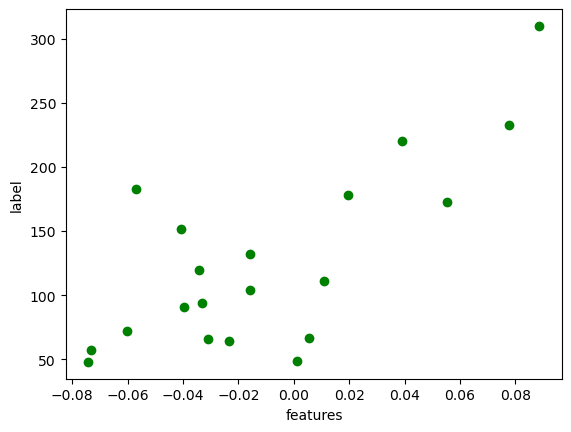

In [85]:
plt.scatter(diabetes_X_test, diabetes_y_test, color = "green")
plt.xlabel("features"), plt.ylabel("label")

iteration: 0, cost: 28216.525
iteration: 1000, cost: 6399.196
iteration: 2000, cost: 3445.546
iteration: 3000, cost: 3042.280
iteration: 4000, cost: 2983.844
iteration: 5000, cost: 2972.046
iteration: 6000, cost: 2966.572
iteration: 7000, cost: 2961.970
iteration: 8000, cost: 2957.503
iteration: 9000, cost: 2953.072
iteration: 10000, cost: 2948.663
iteration: 11000, cost: 2944.274
iteration: 12000, cost: 2939.905
iteration: 13000, cost: 2935.556
iteration: 14000, cost: 2931.227
iteration: 15000, cost: 2926.917
iteration: 16000, cost: 2922.626
iteration: 17000, cost: 2918.355
iteration: 18000, cost: 2914.103
iteration: 19000, cost: 2909.871


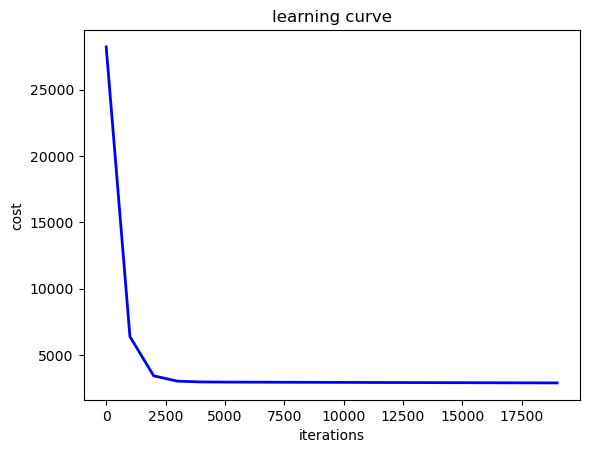

In [86]:
# Now train...
model = Model(diabetes_X_train, diabetes_y_train)
params = model.initailize_params()
# print(params.shape)
params = train(diabetes_X_train, diabetes_y_train, model, params, regression = None)

## SKlearn implementation


Coefficients: 
 [938.23786125]
Mean squared error: 2548.07
Coefficient of determination: 0.47


ValueError: x and y must have same first dimension, but have shapes (20, 1) and (422, 1)

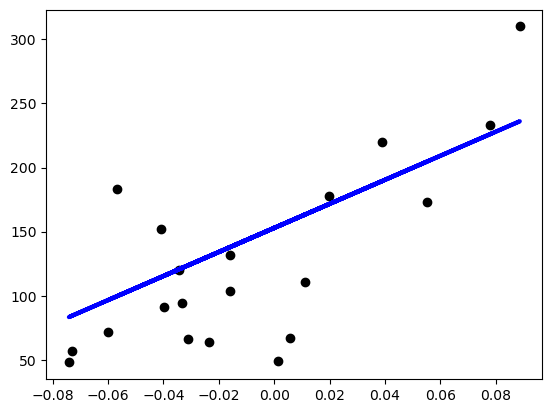

In [87]:
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(diabetes_X_train, diabetes_y_train)

# Make predictions using the testing set
diabetes_y_pred = regr.predict(diabetes_X_test)

# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(diabetes_y_test, diabetes_y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(diabetes_y_test, diabetes_y_pred))

# Plot outputs
plt.scatter(diabetes_X_test, diabetes_y_test, color="black")
cus_pred = model.linear_regression(params)
plt.plot(diabetes_X_test, diabetes_y_pred, color="blue", linewidth=3)
plt.plot(diabetes_X_test, cus_pred, color="green", linewidth = 3)

plt.xticks(())
plt.yticks(())

plt.show()

In [91]:
diabetes_X_test = np.insert(diabetes_X_test, 0, 1, axis =1)
diabetes_X_test.shape

(20, 3)

In [71]:
X_dummy = np.linspace(1, 100, 50).reshape(1, -1).T

In [52]:
Y_dummy = 3 * X_dummy + 1

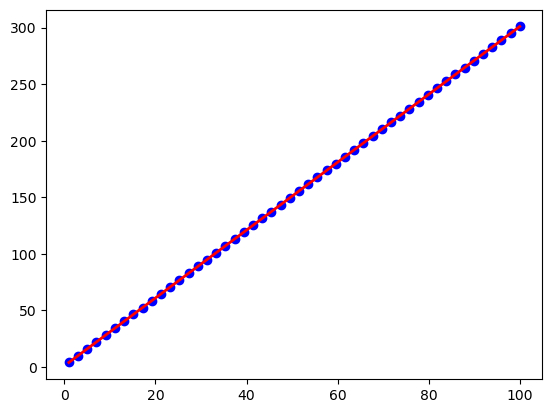

In [61]:
plt.plot(X_dummy, Y_dummy, 'r-', linewidth = 2)
plt.scatter(X_dummy, Y_dummy, color = 'b')
plt.show()